In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-learning-to-count/train.txt
/kaggle/input/mlub-learning-to-count/test/test/test_composite000000426.png
/kaggle/input/mlub-learning-to-count/train/train/train_composite000012068.png


In [2]:
df_train = pd.read_csv('/kaggle/input/mlub-learning-to-count/train.txt',sep=' ',header=None)

# take only the first 200 images
df_train = df_train.head(500)

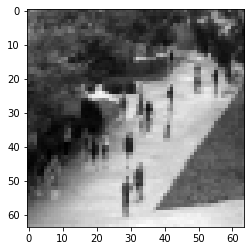

In [3]:
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt
# read images and store into a np array

data_dir = '/kaggle/input/mlub-learning-to-count/train/'
im_size = 64
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont =0

for ind, item in df_train.iterrows():
    im       = imageio.imread(data_dir + item[0])/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont+=1

plt.imshow(small_im,cmap='gray')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.33, random_state=66)

In [5]:
from sklearn.ensemble import RandomForestRegressor
# random forest model 
rfc = RandomForestRegressor()
rfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)
# predictions
rfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))


5.3179192216960995


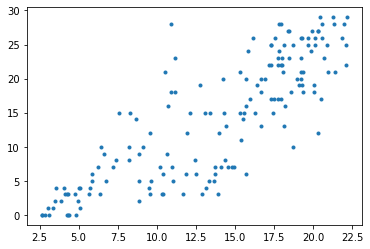

In [6]:
from sklearn.metrics import mean_squared_error
plt.plot(rfc_predict,y_val,'.')

print(np.sqrt(mean_squared_error(rfc_predict,y_val)))

In [7]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
history = {}

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

In [9]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# create the model
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128, input_shape=[32, 32, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(input_shape=[16, 16, 1]),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=30, activation='softmax')
])

In [10]:
model.layers

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=500,
                    validation_data=(X_val, y_val),verbose=1)

Epoch 1/500
11/11 [==============================] - 0s 42ms/step - loss: 3.4086 - accuracy: 0.0328 - val_loss: 3.4031 - val_accuracy: 0.0242
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 3.3997 - accuracy: 0.0418 - val_loss: 3.4016 - val_accuracy: 0.0242
Epoch 3/500
11/11 [==============================] - 0s 12ms/step - loss: 3.3962 - accuracy: 0.0418 - val_loss: 3.4022 - val_accuracy: 0.0242
Epoch 4/500
11/11 [==============================] - 0s 9ms/step - loss: 3.3914 - accuracy: 0.0418 - val_loss: 3.4128 - val_accuracy: 0.0242
Epoch 5/500
11/11 [==============================] - 0s 9ms/step - loss: 3.3845 - accuracy: 0.0418 - val_loss: 3.4129 - val_accuracy: 0.0242
Epoch 6/500
11/11 [==============================] - 0s 9ms/step - loss: 3.3781 - accuracy: 0.0328 - val_loss: 3.4106 - val_accuracy: 0.0424
Epoch 7/500
11/11 [==============================] - 0s 10ms/step - loss: 3.3753 - accuracy: 0.0537 - val_loss: 3.4190 - val_accuracy: 0.0485
Epoch 8/5

Epoch 59/500
11/11 [==============================] - 0s 9ms/step - loss: 1.6128 - accuracy: 0.4418 - val_loss: 3.1178 - val_accuracy: 0.2182
Epoch 60/500
11/11 [==============================] - 0s 9ms/step - loss: 1.7082 - accuracy: 0.3731 - val_loss: 3.0555 - val_accuracy: 0.1758
Epoch 61/500
11/11 [==============================] - 0s 9ms/step - loss: 1.6492 - accuracy: 0.3731 - val_loss: 3.0828 - val_accuracy: 0.2121
Epoch 62/500
11/11 [==============================] - 0s 9ms/step - loss: 1.6446 - accuracy: 0.4119 - val_loss: 2.9698 - val_accuracy: 0.1818
Epoch 63/500
11/11 [==============================] - 0s 9ms/step - loss: 1.6423 - accuracy: 0.3881 - val_loss: 3.1994 - val_accuracy: 0.1636
Epoch 64/500
11/11 [==============================] - 0s 9ms/step - loss: 1.6233 - accuracy: 0.4060 - val_loss: 3.0046 - val_accuracy: 0.2000
Epoch 65/500
11/11 [==============================] - 0s 9ms/step - loss: 1.6196 - accuracy: 0.4179 - val_loss: 3.0081 - val_accuracy: 0.1939
Epoch 

11/11 [==============================] - 0s 9ms/step - loss: 0.8832 - accuracy: 0.6985 - val_loss: 4.5489 - val_accuracy: 0.2061
Epoch 117/500
11/11 [==============================] - 0s 9ms/step - loss: 0.8803 - accuracy: 0.7015 - val_loss: 4.9121 - val_accuracy: 0.2424
Epoch 118/500
11/11 [==============================] - 0s 9ms/step - loss: 0.8900 - accuracy: 0.6716 - val_loss: 4.7873 - val_accuracy: 0.2000
Epoch 119/500
11/11 [==============================] - 0s 9ms/step - loss: 0.9166 - accuracy: 0.6418 - val_loss: 4.7952 - val_accuracy: 0.2606
Epoch 120/500
11/11 [==============================] - 0s 9ms/step - loss: 0.8013 - accuracy: 0.7582 - val_loss: 4.9177 - val_accuracy: 0.2545
Epoch 121/500
11/11 [==============================] - 0s 9ms/step - loss: 0.8432 - accuracy: 0.6716 - val_loss: 4.8380 - val_accuracy: 0.2061
Epoch 122/500
11/11 [==============================] - 0s 9ms/step - loss: 0.9836 - accuracy: 0.6299 - val_loss: 4.9070 - val_accuracy: 0.2303
Epoch 123/500

11/11 [==============================] - 0s 9ms/step - loss: 0.3071 - accuracy: 0.9045 - val_loss: 8.4239 - val_accuracy: 0.2121
Epoch 174/500
11/11 [==============================] - 0s 9ms/step - loss: 0.2940 - accuracy: 0.9164 - val_loss: 8.6524 - val_accuracy: 0.2364
Epoch 175/500
11/11 [==============================] - 0s 9ms/step - loss: 0.2756 - accuracy: 0.9194 - val_loss: 8.6433 - val_accuracy: 0.2485
Epoch 176/500
11/11 [==============================] - 0s 9ms/step - loss: 0.2589 - accuracy: 0.9194 - val_loss: 9.1009 - val_accuracy: 0.2303
Epoch 177/500
11/11 [==============================] - 0s 9ms/step - loss: 0.2733 - accuracy: 0.9284 - val_loss: 9.0507 - val_accuracy: 0.2424
Epoch 178/500
11/11 [==============================] - 0s 9ms/step - loss: 0.2711 - accuracy: 0.9254 - val_loss: 8.8865 - val_accuracy: 0.2242
Epoch 179/500
11/11 [==============================] - 0s 11ms/step - loss: 0.2991 - accuracy: 0.9104 - val_loss: 9.0210 - val_accuracy: 0.2242
Epoch 180/50

11/11 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.9642 - val_loss: 12.6071 - val_accuracy: 0.2242
Epoch 231/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1023 - accuracy: 0.9791 - val_loss: 13.0376 - val_accuracy: 0.2303
Epoch 232/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0836 - accuracy: 0.9910 - val_loss: 13.2955 - val_accuracy: 0.2242
Epoch 233/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0559 - accuracy: 1.0000 - val_loss: 13.2328 - val_accuracy: 0.2303
Epoch 234/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0545 - accuracy: 0.9970 - val_loss: 13.4097 - val_accuracy: 0.2364
Epoch 235/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0508 - accuracy: 0.9940 - val_loss: 13.8188 - val_accuracy: 0.2061
Epoch 236/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0684 - accuracy: 0.9940 - val_loss: 13.6672 - val_accuracy: 0.2182
Epoch 

Epoch 287/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 16.3883 - val_accuracy: 0.2303
Epoch 288/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9970 - val_loss: 16.4512 - val_accuracy: 0.2424
Epoch 289/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 0.9970 - val_loss: 16.6046 - val_accuracy: 0.2242
Epoch 290/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 16.5815 - val_accuracy: 0.2303
Epoch 291/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 16.6542 - val_accuracy: 0.2364
Epoch 292/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 16.6702 - val_accuracy: 0.2242
Epoch 293/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 16.7390 - val_accuracy:

Epoch 344/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 18.1763 - val_accuracy: 0.2242
Epoch 345/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 18.2609 - val_accuracy: 0.2121
Epoch 346/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 18.2543 - val_accuracy: 0.2242
Epoch 347/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 18.2043 - val_accuracy: 0.2242
Epoch 348/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 18.2653 - val_accuracy: 0.2242
Epoch 349/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0163 - accuracy: 0.9970 - val_loss: 18.5333 - val_accuracy: 0.2182
Epoch 350/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9970 - val_loss: 18.4107 - val_accuracy:

Epoch 401/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 19.8957 - val_accuracy: 0.2242
Epoch 402/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 19.9180 - val_accuracy: 0.2242
Epoch 403/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 19.9770 - val_accuracy: 0.2242
Epoch 404/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 19.9771 - val_accuracy: 0.2242
Epoch 405/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 20.0184 - val_accuracy: 0.2242
Epoch 406/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 19.9908 - val_accuracy: 0.2242
Epoch 407/500
11/11 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 20.0765 - val_accura

Epoch 458/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.0530 - val_accuracy: 0.2242
Epoch 459/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.0369 - val_accuracy: 0.2182
Epoch 460/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.0576 - val_accuracy: 0.2182
Epoch 461/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.0900 - val_accuracy: 0.2182
Epoch 462/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 21.1072 - val_accuracy: 0.2182
Epoch 463/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 21.1103 - val_accuracy: 0.2182
Epoch 464/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 21.1492 - val_accuracy:

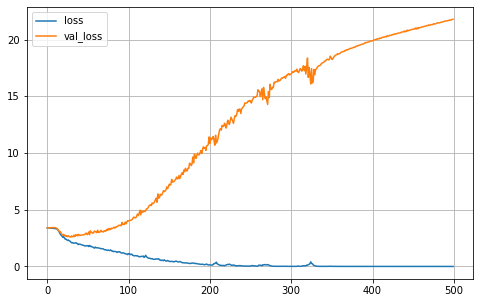

In [14]:
import pandas as pd

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

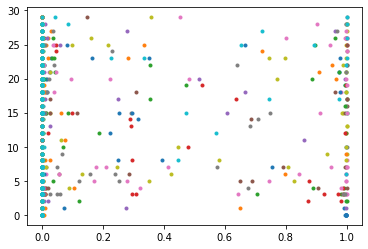

In [15]:
y_model1 = model.predict(X_val)

plt.plot(y_model1,y_val,'.')
#np.sqrt(mean_squared_error(y_model1,y_val))

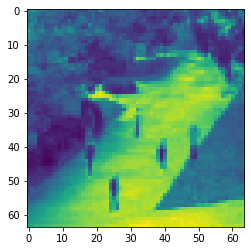

In [27]:
## evaluate test and generate submission
test_dir = '/kaggle/input/mlub-learning-to-count/test/test/'
im_size = 64
N = 500
X_test = np.zeros((N, im_size,im_size))
cont =0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont+=1
    
plt.imshow(small_im)
plt.show()

In [17]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [18]:
# create the file to make the sumbission

y_test = model.predict(X_test)
print(y_test)
y_test = [np.argmax(x) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')


[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.9942327e-01
  2.5718309e-06 4.3117254e-13]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.2208448e-14
  8.6301243e-01 8.2522750e-10]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [8.6053057e-12 5.6093968e-03 2.9408843e-03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.6092135e-23
  7.9819108e-24 2.8127497e-33]
 [0.0000000e+00 0.0000000e+00 9.0477492e-17 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [19]:
print(y_test)

[27, 28, 18, 26, 21, 12, 29, 21, 1, 8, 21, 2, 7, 20, 22, 5, 12, 4, 21, 26, 4, 26, 29, 8, 14, 0, 5, 1, 5, 4, 11, 17, 12, 19, 22, 0, 15, 7, 3, 6, 19, 18, 6, 27, 19, 15, 19, 29, 2, 20, 26, 2, 25, 8, 1, 29, 7, 15, 15, 26, 24, 14, 15, 4, 6, 15, 0, 6, 10, 11, 23, 1, 0, 6, 27, 8, 8, 18, 17, 25, 6, 24, 24, 27, 4, 29, 23, 25, 24, 19, 19, 23, 25, 4, 23, 24, 12, 14, 1, 5, 10, 15, 29, 21, 28, 5, 12, 22, 18, 6, 29, 19, 25, 29, 25, 10, 6, 6, 5, 10, 28, 6, 3, 22, 14, 12, 6, 18, 3, 19, 18, 15, 2, 18, 17, 15, 11, 19, 7, 5, 14, 4, 17, 17, 0, 15, 21, 22, 15, 14, 7, 14, 15, 19, 7, 2, 19, 8, 25, 29, 0, 15, 19, 20, 19, 18, 11, 21, 22, 5, 14, 13, 27, 23, 11, 9, 26, 19, 1, 24, 1, 23, 4, 27, 11, 12, 26, 25, 24, 12, 17, 8, 24, 21, 12, 14, 15, 21, 9, 28, 29, 10, 24, 10, 18, 29, 15, 29, 18, 7, 25, 28, 13, 18, 24, 10, 6, 5, 14, 0, 13, 1, 25, 26, 27, 5, 24, 12, 10, 0, 25, 23, 6, 27, 10, 5, 26, 23, 6, 0, 8, 18, 6, 1, 7, 29, 6, 11, 27, 12, 7, 12, 12, 1, 7, 6, 27, 2, 23, 6, 26, 0, 27, 28, 1, 7, 0, 7, 10, 4, 5, 3, 18, 

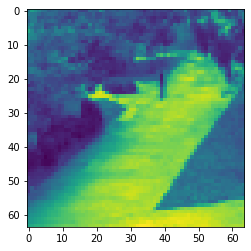

In [29]:
plt.imshow(X_test[8])
